# Document Check - Monthly Trend Analysis
## Analyzing all result columns over time to identify patterns and potential issues

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the Document Check dataset
doc_check_df = pd.read_csv('Data/Document-check-report.csv')

# Convert created_at to datetime and extract year-month
doc_check_df['created_at'] = pd.to_datetime(doc_check_df['created_at'])
doc_check_df['year_month'] = doc_check_df['created_at'].dt.to_period('M')

print(f"Total Records: {len(doc_check_df):,}")
print(f"Date Range: {doc_check_df['created_at'].min()} to {doc_check_df['created_at'].max()}")
print(f"Number of Months: {doc_check_df['year_month'].nunique()}")

Total Records: 176,404
Date Range: 2021-05-23 15:13:02+00:00 to 2021-10-31 23:54:24+00:00
Number of Months: 6


In [2]:
# Define all result columns to analyze
result_columns = [
    'result',
    'visual_authenticity_result',
    'image_integrity_result',
    'face_detection_result',
    'image_quality_result',
    'supported_document_result',
    'conclusive_document_quality_result',
    'data_validation_result',
    'data_consistency_result',
    'data_comparison_result',
    'police_record_result',
    'compromised_document_result',
    'sub_result'
]

# Check value counts for each column
print("Value Counts for Each Result Column:")
print("=" * 60)
for col in result_columns:
    print(f"\n{col}:")
    print(doc_check_df[col].value_counts(dropna=False).head(5))

Value Counts for Each Result Column:

result:
result
clear       132402
consider     44002
Name: count, dtype: int64

visual_authenticity_result:
visual_authenticity_result
clear       147260
NaN          26114
consider      3030
Name: count, dtype: int64

image_integrity_result:
image_integrity_result
clear       136660
consider     39743
NaN              1
Name: count, dtype: int64

face_detection_result:
face_detection_result
clear       149687
NaN          26143
consider       574
Name: count, dtype: int64

image_quality_result:
image_quality_result
clear           152000
unidentified     24403
NaN                  1
Name: count, dtype: int64

supported_document_result:
supported_document_result
clear           174213
unidentified      1687
NaN                504
Name: count, dtype: int64

conclusive_document_quality_result:
conclusive_document_quality_result
clear       81652
NaN         81187
consider    13565
Name: count, dtype: int64

data_validation_result:
data_validation_res

In [3]:
# Function to calculate monthly pass rate (clear rate) for each column
def calculate_monthly_rates(df, column):
    """Calculate monthly pass rate for a given result column"""
    monthly = df.groupby('year_month').agg(
        total=('user_id', 'count'),
        clear_count=(column, lambda x: (x == 'clear').sum()),
        consider_count=(column, lambda x: (x == 'consider').sum()),
        null_count=(column, lambda x: x.isna().sum())
    ).reset_index()
    
    # Calculate rates (excluding nulls from denominator for accurate rates)
    valid_count = monthly['total'] - monthly['null_count']
    monthly['pass_rate'] = (monthly['clear_count'] / valid_count * 100).replace([np.inf, -np.inf], np.nan)
    monthly['fail_rate'] = (monthly['consider_count'] / valid_count * 100).replace([np.inf, -np.inf], np.nan)
    monthly['year_month_dt'] = monthly['year_month'].dt.to_timestamp()
    
    return monthly

# Calculate monthly rates for all columns
monthly_data = {}
for col in result_columns:
    monthly_data[col] = calculate_monthly_rates(doc_check_df, col)
    
print("Monthly data calculated for all result columns ✅")

Monthly data calculated for all result columns ✅


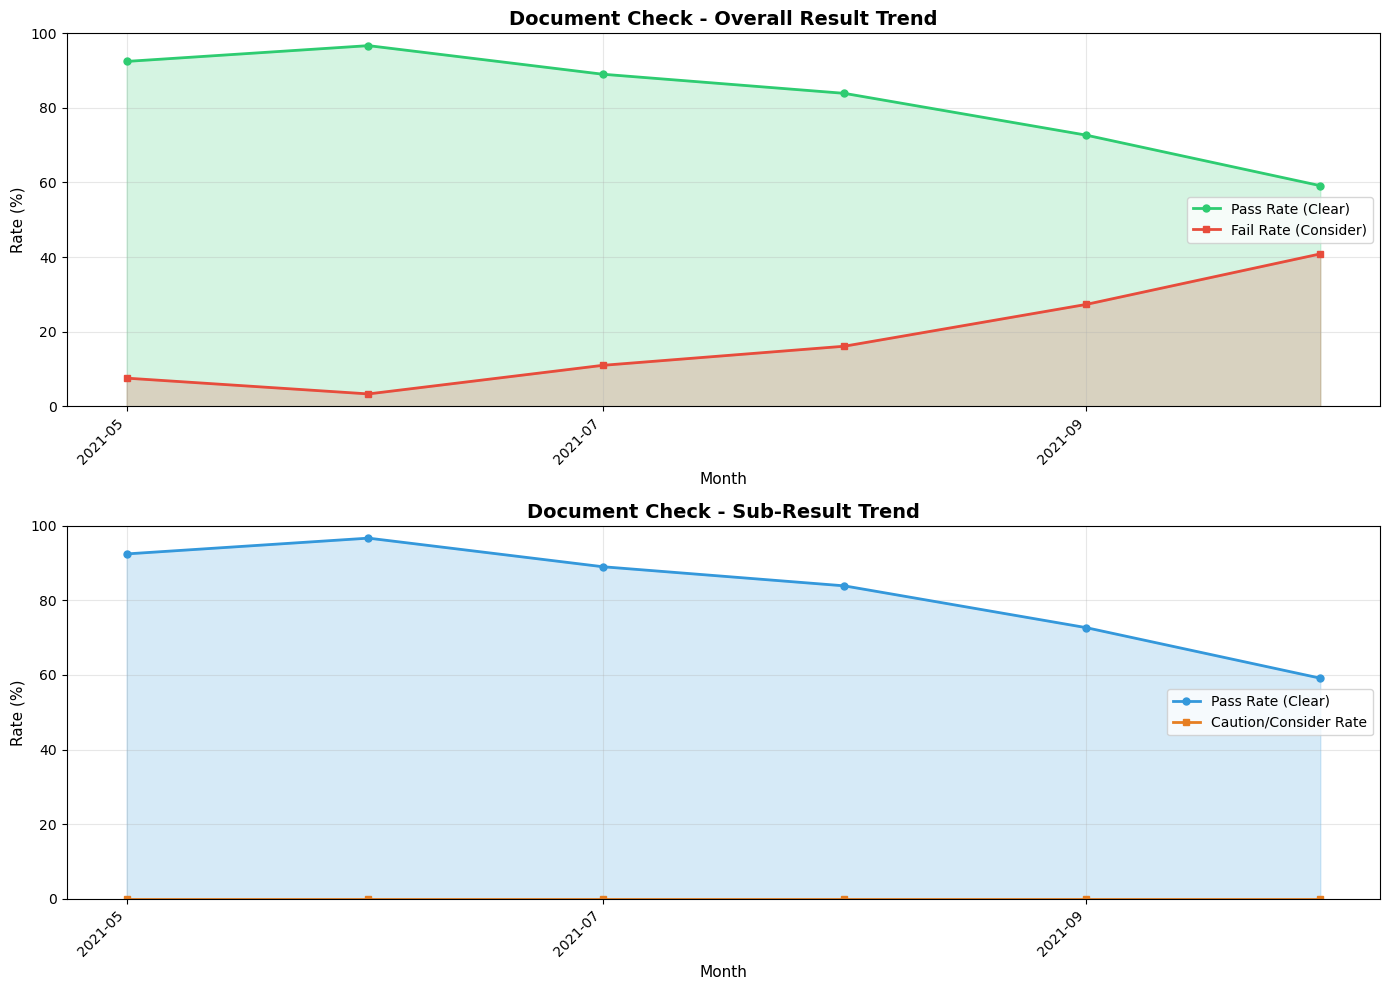

✅ Chart saved as 'main_result_trend.png'


In [4]:
# Plot 1: Main Result Column Trend
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Main result pass rate
ax1 = axes[0]
data = monthly_data['result']
ax1.plot(data['year_month_dt'], data['pass_rate'], marker='o', linewidth=2, 
         color='#2ecc71', markersize=5, label='Pass Rate (Clear)')
ax1.plot(data['year_month_dt'], data['fail_rate'], marker='s', linewidth=2, 
         color='#e74c3c', markersize=5, label='Fail Rate (Consider)')
ax1.fill_between(data['year_month_dt'], data['pass_rate'], alpha=0.2, color='#2ecc71')
ax1.fill_between(data['year_month_dt'], data['fail_rate'], alpha=0.2, color='#e74c3c')
ax1.set_title('Document Check - Overall Result Trend', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=11)
ax1.set_ylabel('Rate (%)', fontsize=11)
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='center right', fontsize=10)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Sub-result trend
ax2 = axes[1]
data = monthly_data['sub_result']
ax2.plot(data['year_month_dt'], data['pass_rate'], marker='o', linewidth=2, 
         color='#3498db', markersize=5, label='Pass Rate (Clear)')
ax2.plot(data['year_month_dt'], data['fail_rate'], marker='s', linewidth=2, 
         color='#e67e22', markersize=5, label='Caution/Consider Rate')
ax2.fill_between(data['year_month_dt'], data['pass_rate'], alpha=0.2, color='#3498db')
ax2.set_title('Document Check - Sub-Result Trend', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=11)
ax2.set_ylabel('Rate (%)', fontsize=11)
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='center right', fontsize=10)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('main_result_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'main_result_trend.png'")

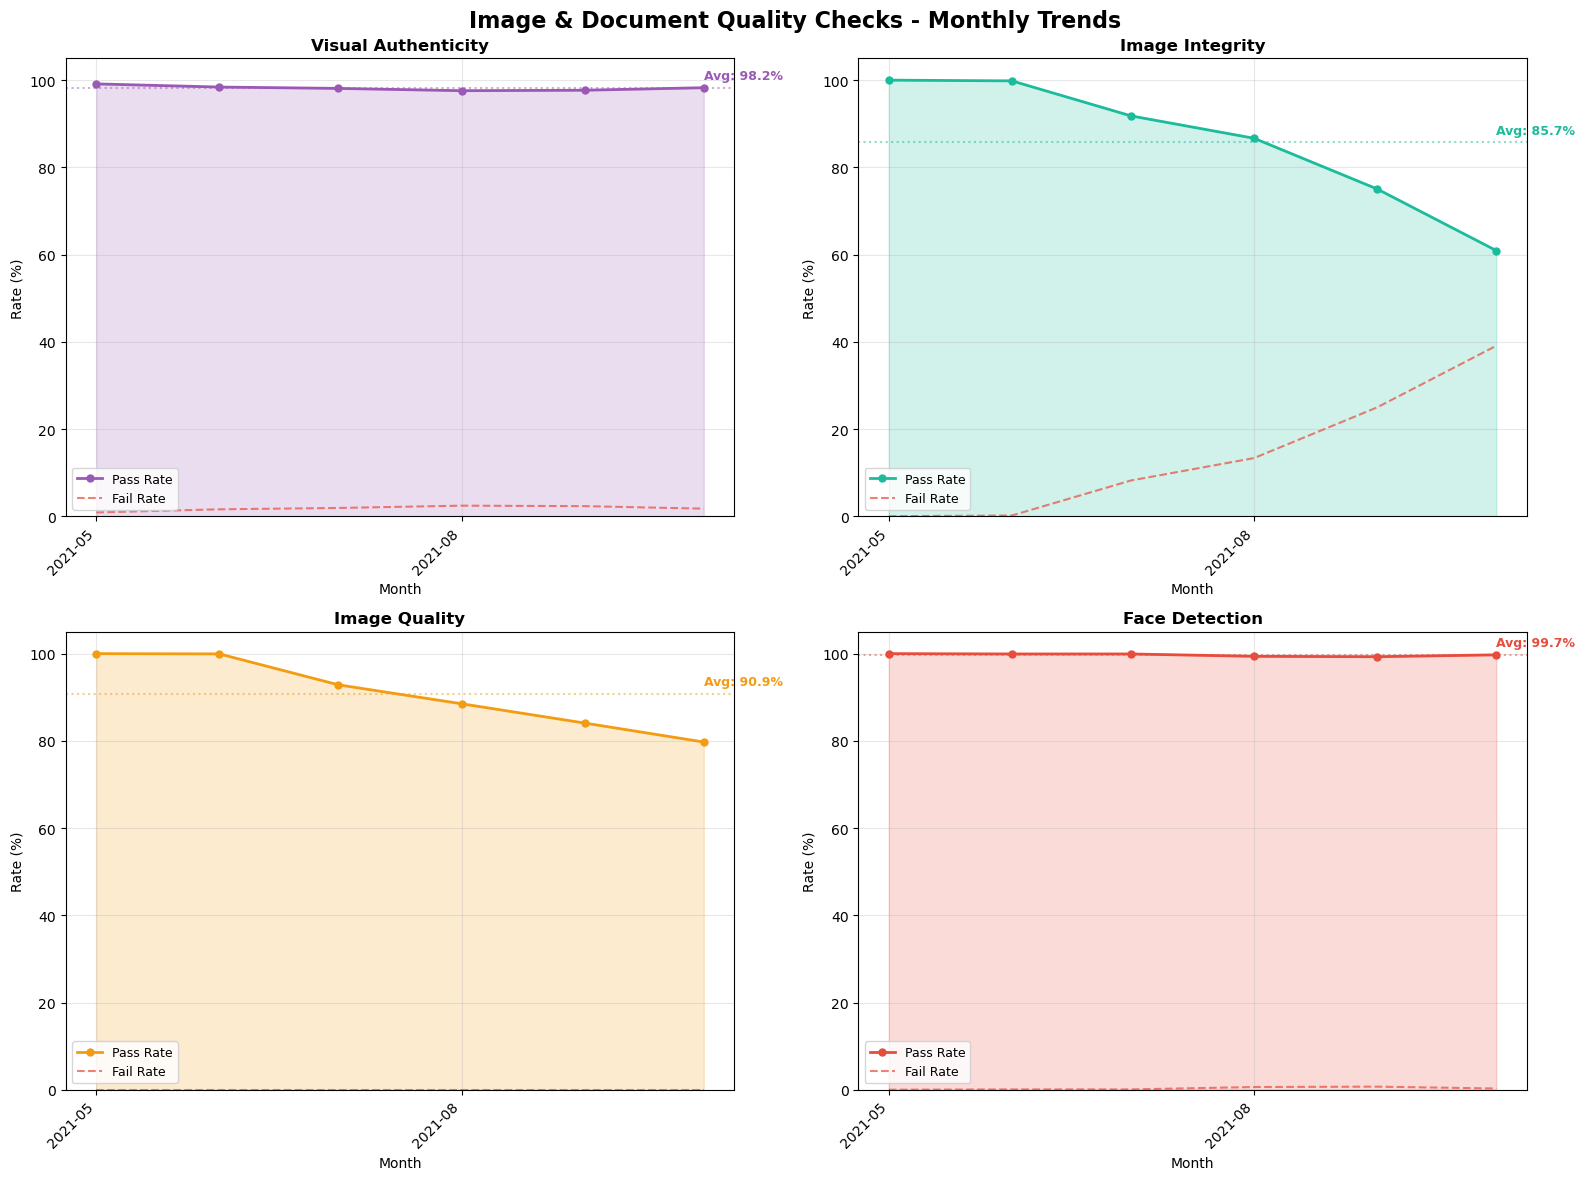

✅ Chart saved as 'quality_checks_trend.png'


In [5]:
# Plot 2: Image & Document Quality Checks
quality_cols = ['visual_authenticity_result', 'image_integrity_result', 
                'image_quality_result', 'face_detection_result']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Image & Document Quality Checks - Monthly Trends', fontsize=16, fontweight='bold')

colors = ['#9b59b6', '#1abc9c', '#f39c12', '#e74c3c']

for idx, col in enumerate(quality_cols):
    ax = axes[idx // 2, idx % 2]
    data = monthly_data[col]
    
    ax.plot(data['year_month_dt'], data['pass_rate'], marker='o', linewidth=2, 
            color=colors[idx], markersize=5, label='Pass Rate')
    ax.fill_between(data['year_month_dt'], data['pass_rate'], alpha=0.2, color=colors[idx])
    
    # Add fail rate as dashed line
    ax.plot(data['year_month_dt'], data['fail_rate'], linestyle='--', linewidth=1.5, 
            color='#e74c3c', alpha=0.7, label='Fail Rate')
    
    col_title = col.replace('_', ' ').title().replace(' Result', '')
    ax.set_title(f'{col_title}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('Rate (%)', fontsize=10)
    ax.set_ylim(0, 105)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower left', fontsize=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add average annotation
    avg_pass = data['pass_rate'].mean()
    ax.axhline(y=avg_pass, color=colors[idx], linestyle=':', alpha=0.5)
    ax.text(data['year_month_dt'].iloc[-1], avg_pass + 2, f'Avg: {avg_pass:.1f}%', 
            fontsize=9, color=colors[idx], fontweight='bold')

plt.tight_layout()
plt.savefig('quality_checks_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'quality_checks_trend.png'")

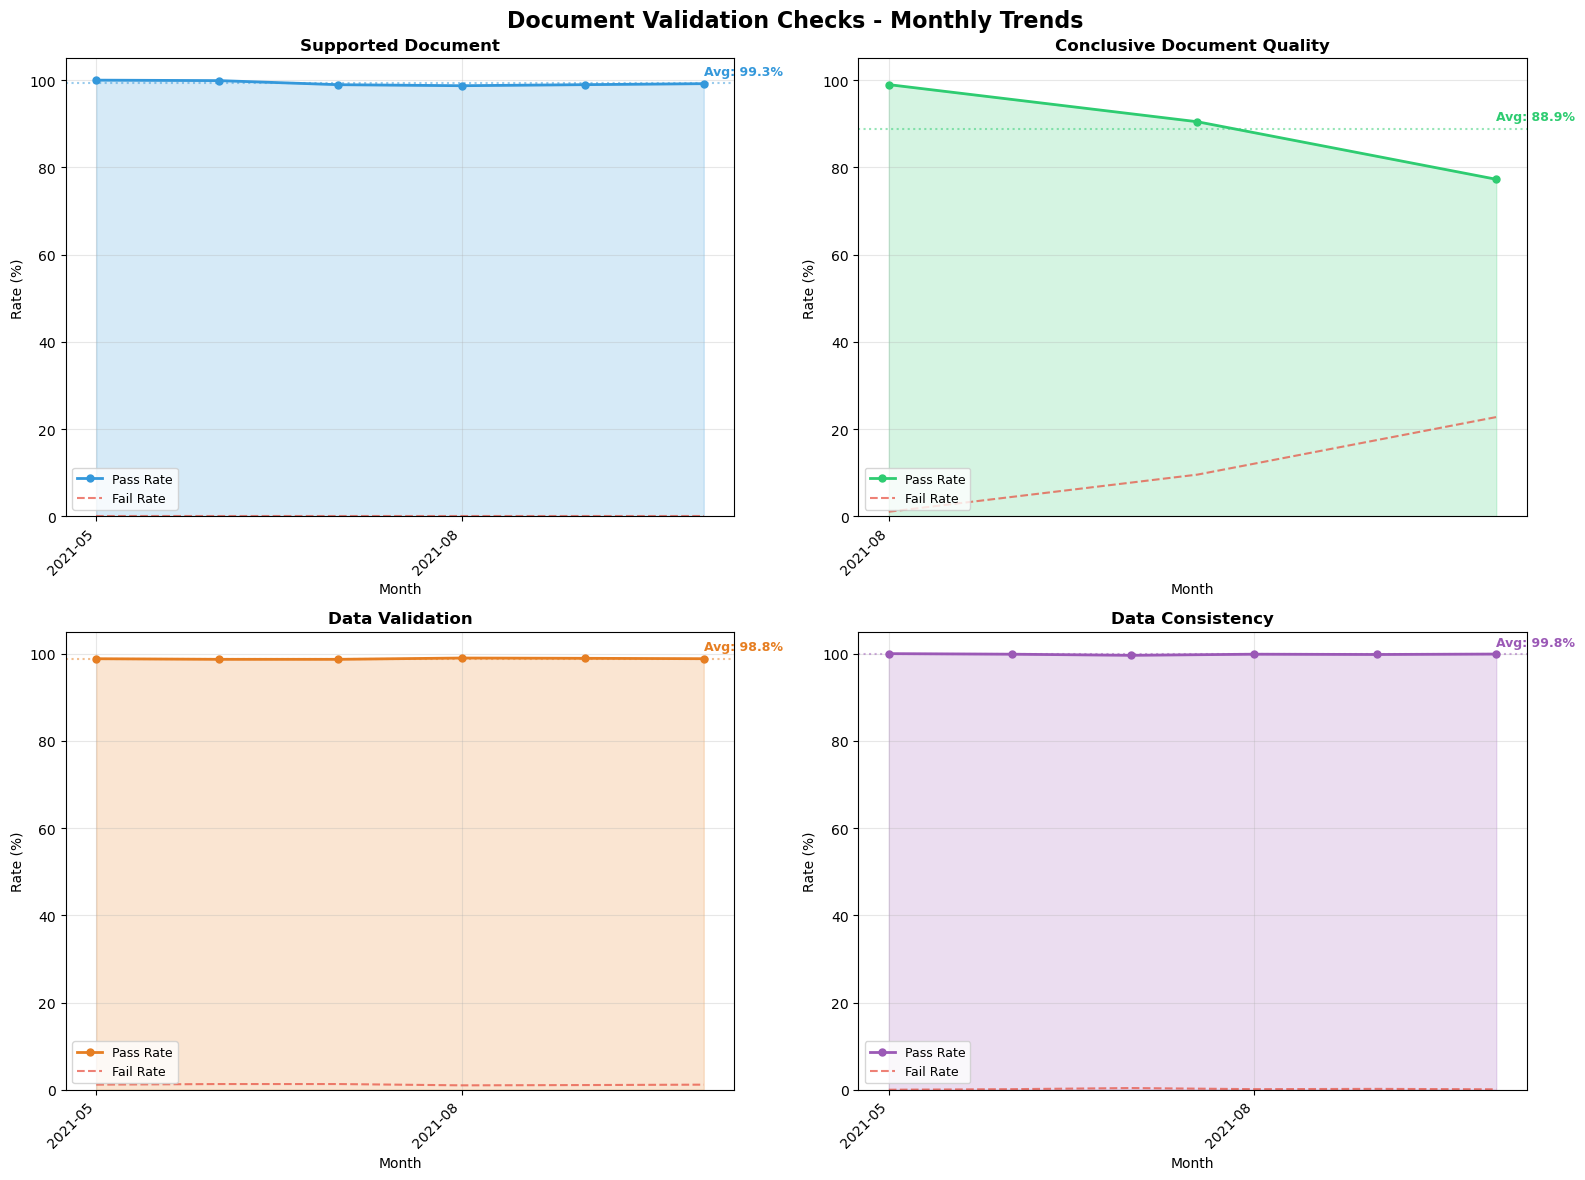

✅ Chart saved as 'validation_checks_trend.png'


In [6]:
# Plot 3: Document Validation Checks
validation_cols = ['supported_document_result', 'conclusive_document_quality_result',
                   'data_validation_result', 'data_consistency_result']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Document Validation Checks - Monthly Trends', fontsize=16, fontweight='bold')

colors = ['#3498db', '#2ecc71', '#e67e22', '#9b59b6']

for idx, col in enumerate(validation_cols):
    ax = axes[idx // 2, idx % 2]
    data = monthly_data[col]
    
    ax.plot(data['year_month_dt'], data['pass_rate'], marker='o', linewidth=2, 
            color=colors[idx], markersize=5, label='Pass Rate')
    ax.fill_between(data['year_month_dt'], data['pass_rate'], alpha=0.2, color=colors[idx])
    
    ax.plot(data['year_month_dt'], data['fail_rate'], linestyle='--', linewidth=1.5, 
            color='#e74c3c', alpha=0.7, label='Fail Rate')
    
    col_title = col.replace('_', ' ').title().replace(' Result', '')
    ax.set_title(f'{col_title}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('Rate (%)', fontsize=10)
    ax.set_ylim(0, 105)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower left', fontsize=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    avg_pass = data['pass_rate'].mean()
    ax.axhline(y=avg_pass, color=colors[idx], linestyle=':', alpha=0.5)
    ax.text(data['year_month_dt'].iloc[-1], avg_pass + 2, f'Avg: {avg_pass:.1f}%', 
            fontsize=9, color=colors[idx], fontweight='bold')

plt.tight_layout()
plt.savefig('validation_checks_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'validation_checks_trend.png'")

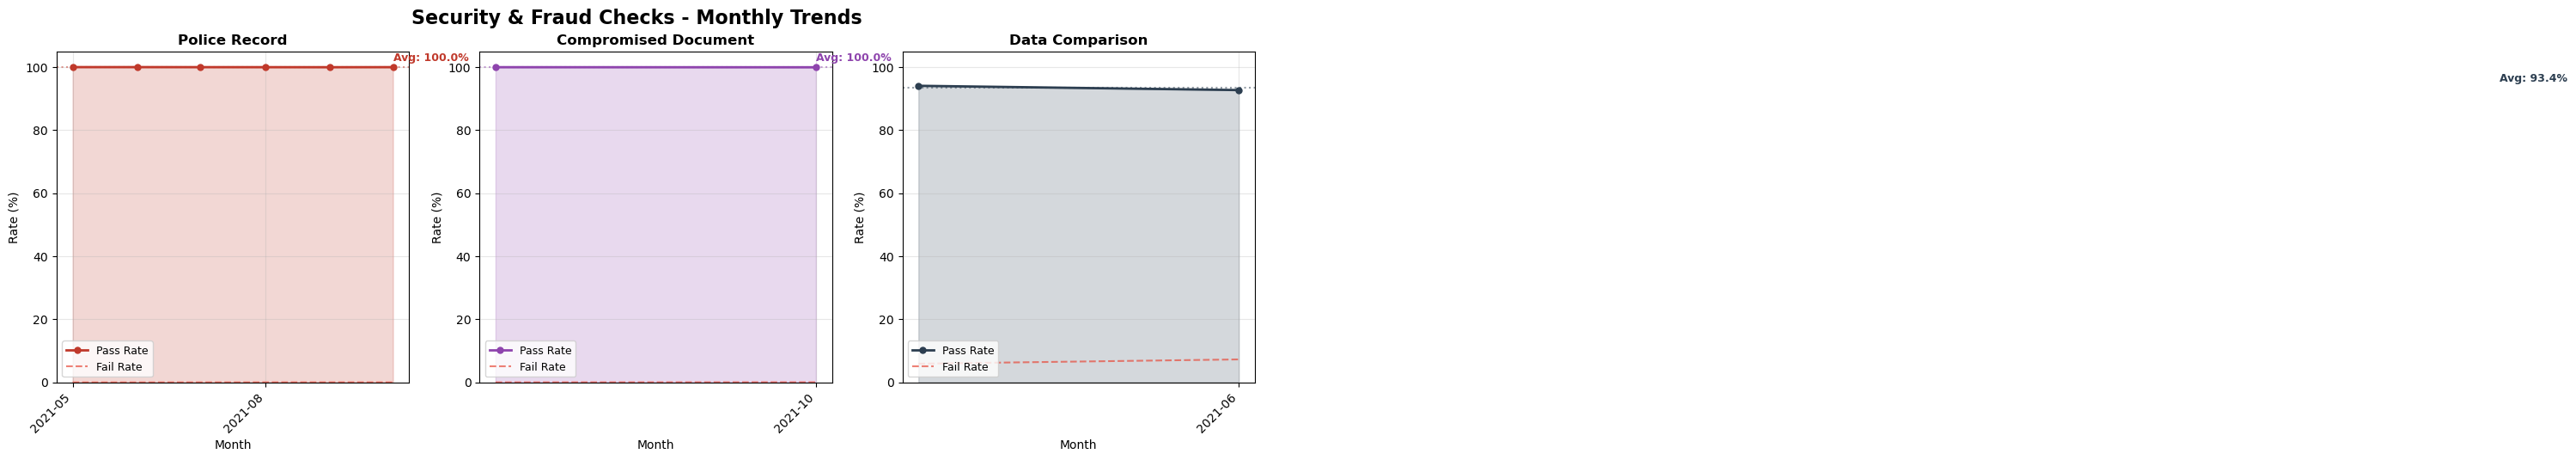

✅ Chart saved as 'security_checks_trend.png'


In [7]:
# Plot 4: Security & Fraud Checks
security_cols = ['police_record_result', 'compromised_document_result', 'data_comparison_result']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Security & Fraud Checks - Monthly Trends', fontsize=16, fontweight='bold')

colors = ['#c0392b', '#8e44ad', '#2c3e50']

for idx, col in enumerate(security_cols):
    ax = axes[idx]
    data = monthly_data[col]
    
    ax.plot(data['year_month_dt'], data['pass_rate'], marker='o', linewidth=2, 
            color=colors[idx], markersize=5, label='Pass Rate')
    ax.fill_between(data['year_month_dt'], data['pass_rate'], alpha=0.2, color=colors[idx])
    
    ax.plot(data['year_month_dt'], data['fail_rate'], linestyle='--', linewidth=1.5, 
            color='#e74c3c', alpha=0.7, label='Fail Rate')
    
    col_title = col.replace('_', ' ').title().replace(' Result', '')
    ax.set_title(f'{col_title}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('Rate (%)', fontsize=10)
    ax.set_ylim(0, 105)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower left', fontsize=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    avg_pass = data['pass_rate'].mean()
    if not np.isnan(avg_pass):
        ax.axhline(y=avg_pass, color=colors[idx], linestyle=':', alpha=0.5)
        ax.text(data['year_month_dt'].iloc[-1], avg_pass + 2, f'Avg: {avg_pass:.1f}%', 
                fontsize=9, color=colors[idx], fontweight='bold')

plt.tight_layout()
plt.savefig('security_checks_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'security_checks_trend.png'")

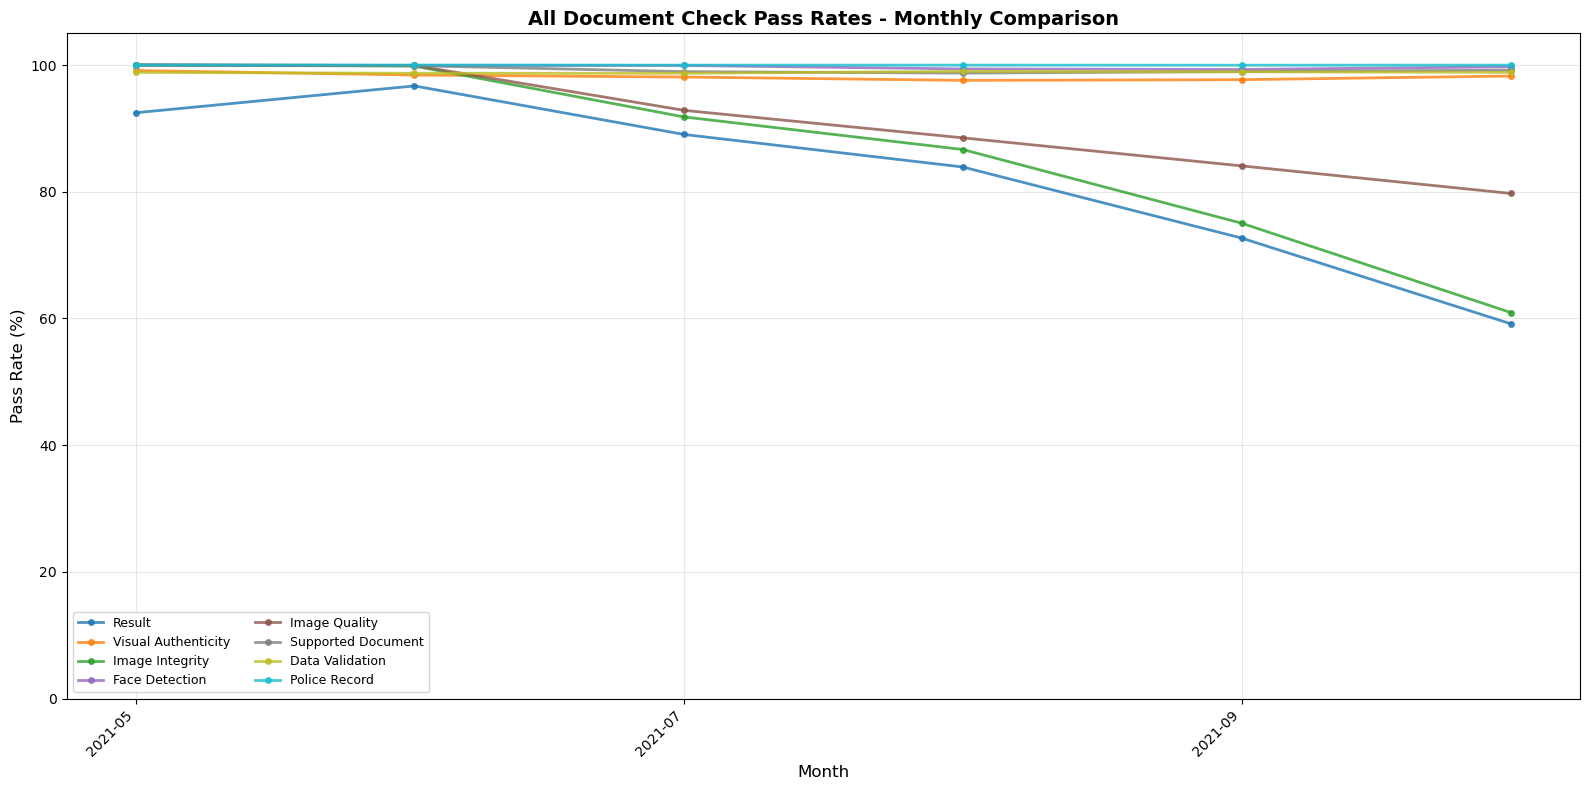

✅ Chart saved as 'all_checks_comparison.png'


In [8]:
# Plot 5: All Pass Rates Comparison on Single Chart
fig, ax = plt.subplots(figsize=(16, 8))

# Define columns to plot (excluding those with too many nulls)
plot_cols = ['result', 'visual_authenticity_result', 'image_integrity_result', 
             'face_detection_result', 'image_quality_result', 'supported_document_result',
             'data_validation_result', 'police_record_result']

colors = plt.cm.tab10(np.linspace(0, 1, len(plot_cols)))

for idx, col in enumerate(plot_cols):
    data = monthly_data[col]
    label = col.replace('_result', '').replace('_', ' ').title()
    ax.plot(data['year_month_dt'], data['pass_rate'], marker='o', linewidth=2, 
            color=colors[idx], markersize=4, label=label, alpha=0.8)

ax.set_title('All Document Check Pass Rates - Monthly Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Pass Rate (%)', fontsize=12)
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3)
ax.legend(loc='lower left', fontsize=9, ncol=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('all_checks_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'all_checks_comparison.png'")

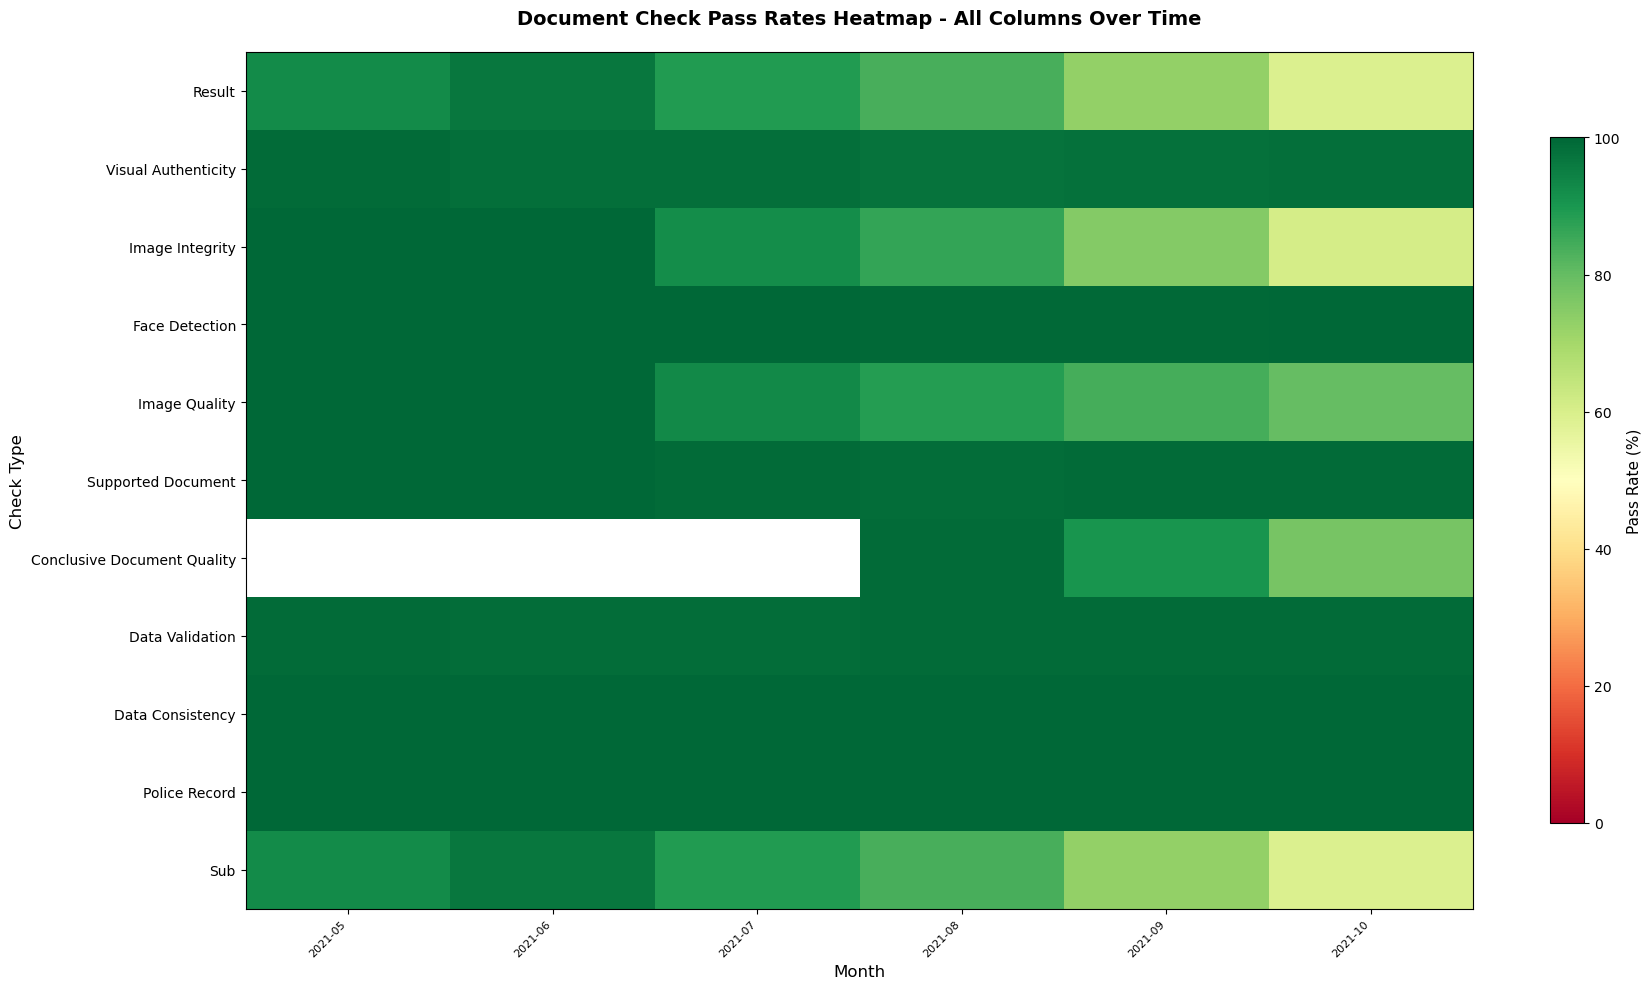

✅ Chart saved as 'pass_rates_heatmap.png'


In [9]:
# Plot 6: Heatmap of All Pass Rates Over Time
# Prepare data for heatmap
heatmap_cols = ['result', 'visual_authenticity_result', 'image_integrity_result', 
                'face_detection_result', 'image_quality_result', 'supported_document_result',
                'conclusive_document_quality_result', 'data_validation_result', 
                'data_consistency_result', 'police_record_result', 'sub_result']

# Create a dataframe for heatmap
heatmap_data = pd.DataFrame()
for col in heatmap_cols:
    data = monthly_data[col]
    label = col.replace('_result', '').replace('_', ' ').title()
    heatmap_data[label] = data['pass_rate'].values

# Use year_month as index
heatmap_data.index = monthly_data['result']['year_month'].astype(str)

fig, ax = plt.subplots(figsize=(18, 10))
im = ax.imshow(heatmap_data.T, aspect='auto', cmap='RdYlGn', vmin=0, vmax=100)

# Set labels
ax.set_xticks(range(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.index, rotation=45, ha='right', fontsize=8)
ax.set_yticks(range(len(heatmap_data.columns)))
ax.set_yticklabels(heatmap_data.columns, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Pass Rate (%)', fontsize=11)

ax.set_title('Document Check Pass Rates Heatmap - All Columns Over Time', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Check Type', fontsize=12)

plt.tight_layout()
plt.savefig('pass_rates_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'pass_rates_heatmap.png'")

In [10]:
# Summary Statistics Table
print("=" * 90)
print("SUMMARY STATISTICS - ALL DOCUMENT CHECK COLUMNS")
print("=" * 90)

summary_data = []
for col in result_columns:
    data = monthly_data[col]
    total_valid = doc_check_df[col].notna().sum()
    overall_pass = (doc_check_df[col] == 'clear').sum() / total_valid * 100 if total_valid > 0 else np.nan
    
    # Trend calculation
    if len(data) >= 4:
        first_half = data['pass_rate'].iloc[:len(data)//2].mean()
        second_half = data['pass_rate'].iloc[len(data)//2:].mean()
        trend = "📈 UP" if second_half > first_half else "📉 DOWN"
        change = second_half - first_half
    else:
        trend = "N/A"
        change = np.nan
    
    summary_data.append({
        'Column': col.replace('_result', '').replace('_', ' ').title(),
        'Valid Records': f"{total_valid:,}",
        'Overall Pass Rate': f"{overall_pass:.1f}%" if not np.isnan(overall_pass) else "N/A",
        'Min Monthly': f"{data['pass_rate'].min():.1f}%",
        'Max Monthly': f"{data['pass_rate'].max():.1f}%",
        'Avg Monthly': f"{data['pass_rate'].mean():.1f}%",
        'Trend': trend,
        'Change (pp)': f"{change:+.1f}" if not np.isnan(change) else "N/A"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("\n" + "=" * 90)
print("pp = percentage points (difference between first half and second half of time period)")
print("=" * 90)

SUMMARY STATISTICS - ALL DOCUMENT CHECK COLUMNS
                     Column Valid Records Overall Pass Rate Min Monthly Max Monthly Avg Monthly  Trend Change (pp)
                     Result       176,404             75.1%       59.1%       96.7%       82.3% 📉 DOWN       -20.8
        Visual Authenticity       150,290             98.0%       97.6%       99.1%       98.2% 📉 DOWN        -0.7
            Image Integrity       176,403             77.5%       60.9%      100.0%       85.7% 📉 DOWN       -23.0
             Face Detection       150,261             99.6%       99.3%      100.0%       99.7% 📉 DOWN        -0.5
              Image Quality       176,403             86.2%       79.7%      100.0%       90.9% 📉 DOWN       -13.5
         Supported Document       175,900             99.0%       98.7%      100.0%       99.3% 📉 DOWN        -0.7
Conclusive Document Quality        95,217             85.8%       77.3%       99.0%       88.9% 📉 DOWN         N/A
            Data Validation     